In [44]:
from collections import Counter
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import  img_to_array
import torchvision
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import supervision as sv
from transformers import DetrImageProcessor
from pycocotools.coco import COCO
import json
import argparse
import shutil
from datetime import datetime

Augmentons les données d'entrainement

In [ ]:
def yolo_to_coco(yolo_dataset_path, output_path, class_names_file=None):
    """
    Convertit un dataset YOLO vers le format COCO en préservant la structure des dossiers
    
    Args:
        yolo_dataset_path (str): Chemin vers le dataset YOLO
        output_path (str): Chemin où sauvegarder le dataset au format COCO
        class_names_file (str, optional): Fichier avec les noms des classes
    """
    # Créer le dossier de sortie principal si nécessaire
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Obtenir les noms des classes
    if class_names_file and os.path.exists(class_names_file):
        with open(class_names_file, 'r') as f:
            class_names = [line.strip() for line in f.readlines()]
    else:
        # Essayer de lire les classes depuis data.yaml
        yaml_file = os.path.join(yolo_dataset_path, "data.yaml")
        if os.path.exists(yaml_file):
            try:
                import yaml
                with open(yaml_file, 'r') as f:
                    yaml_data = yaml.safe_load(f)
                    if 'names' in yaml_data:
                        class_names = yaml_data['names']
                        print(f"Classes lues depuis data.yaml: {class_names}")
                    else:
                        class_names = [f"class_{i}" for i in range(10)]  # Valeur par défaut
            except Exception as e:
                print(f"Erreur lors de la lecture de data.yaml: {e}")
                class_names = [f"class_{i}" for i in range(10)]  # Valeur par défaut
        else:
            class_names = [f"class_{i}" for i in range(10)]  # Valeur par défaut
    
    # Préparer les catégories COCO
    categories = []
    for i, class_name in enumerate(class_names):
        categories.append({
            "id": i,
            "name": class_name,
            "supercategory": "none"
        })
    
    # Identifier les dossiers contenant les images
    image_dirs = []
    
    # Vérifier les dossiers standard
    for folder in ['train', 'test', 'valid', 'val']:
        folder_path = os.path.join(yolo_dataset_path, folder)
        if os.path.isdir(folder_path):
            images_folder = os.path.join(folder_path, 'images')
            if os.path.isdir(images_folder):
                image_dirs.append((folder, images_folder))
            else:
                # Si le sous-dossier 'images' n'existe pas, utiliser le dossier principal
                image_dirs.append((folder, folder_path))
    
    # Si aucun dossier standard n'a été trouvé, vérifier s'il y a un dossier 'images' à la racine
    if not image_dirs:
        images_root = os.path.join(yolo_dataset_path, 'images')
        if os.path.isdir(images_root):
            image_dirs.append(('images', images_root))
        else:
            # En dernier recours, vérifier si des images sont directement à la racine
            if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in os.listdir(yolo_dataset_path)):
                image_dirs.append(('root', yolo_dataset_path))
    
    print(f"Dossiers d'images détectés: {[name for name, _ in image_dirs]}")
    
    # Traiter chaque dossier séparément
    for folder_name, img_dir in image_dirs:
        print(f"\nTraitement du dossier: {folder_name}")
        
        # Créer le dossier de sortie correspondant
        folder_output_path = os.path.join(output_path, folder_name)
        if not os.path.exists(folder_output_path):
            os.makedirs(folder_output_path)
        
        # Initialiser la structure COCO pour ce dossier
        coco_dataset = {
            "info": {
                "description": f"Converted from YOLO format - {folder_name}",
                "url": "",
                "version": "1.0",
                "year": datetime.now().year,
                "contributor": "YOLO to COCO converter",
                "date_created": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            },
            "licenses": [
                {
                    "id": 1,
                    "name": "Unknown",
                    "url": ""
                }
            ],
            "images": [],
            "annotations": [],
            "categories": categories  # Utiliser les mêmes catégories pour tous les dossiers
        }
        
        # Déterminer le dossier d'annotations correspondant
        labels_dir = None
        dir_name = os.path.basename(img_dir)
        parent_dir = os.path.dirname(img_dir)
        
        if dir_name == 'images':
            # Si nous sommes dans un dossier 'images', les labels sont probablement dans '../labels'
            labels_dir = os.path.join(parent_dir, 'labels')
        else:
            # Sinon, vérifier si les labels sont dans le même dossier ou dans un sous-dossier 'labels'
            labels_dir = os.path.join(img_dir, 'labels')
            if not os.path.isdir(labels_dir):
                labels_dir = img_dir
        
        print(f"Dossier d'annotations correspondant: {labels_dir}")
        
        # Récupérer toutes les images
        img_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        image_files = []
        for ext in img_extensions:
            image_files.extend(glob.glob(os.path.join(img_dir, f'*{ext}')))
            image_files.extend(glob.glob(os.path.join(img_dir, f'*{ext.upper()}')))
        
        print(f"Nombre d'images trouvées: {len(image_files)}")
        
        # Parcourir les images et leurs annotations
        annotation_id = 0
        image_id = 0
        i = 0
        for image_path in image_files:
            try:
                # Ignorer les fichiers qui commencent par "README"
                if os.path.basename(image_path).startswith("README"):
                    continue
                
                # Charger l'image pour obtenir les dimensions
                with Image.open(image_path) as img:
                    width, height = img.size
                
                # Obtenir le nom du fichier et l'ID d'image
                image_file = os.path.basename(image_path)
                image_id += 1
                
                # Essayer de convertir le nom de fichier en entier pour l'ID,
                # sinon utiliser un ID séquentiel
                try:
                    img_id = int(os.path.splitext(image_file)[0])
                except:
                    img_id = image_id
                
                # Ajouter l'image à la structure COCO
                coco_dataset["images"].append({
                    "id": img_id,
                    "width": width,
                    "height": height,
                    "file_name": image_file,
                    "license": 1,
                    "date_captured": ""
                })
                
                # Copier l'image vers le dossier de sortie
                shutil.copy(image_path, os.path.join(folder_output_path, image_file))
                
                # Trouver le fichier d'annotation correspondant
                base_filename = os.path.splitext(image_file)[0]
                annotation_file = os.path.join(labels_dir, f"{base_filename}.txt")
                
                if os.path.exists(annotation_file):
                    with open(annotation_file, 'r') as f:
                        annotations = f.readlines()
                    
                    for ann in annotations:
                        try:
                            parts = ann.strip().split()
                            if len(parts) >= 5:
                                class_id = int(parts[0])
                                # Format YOLO: class_id x_center y_center width height (normalisé)
                                x, y, w, h = map(float, parts[1:5])
                                
                                # Convertir les coordonnées YOLO vers COCO
                                x_min = int((x - w/2) * width)
                                y_min = int((y - h/2) * height)
                                bbox_width = int(w * width)
                                bbox_height = int(h * height)
                                
                                annotation_id += 1
                                coco_dataset["annotations"].append({
                                    "id": annotation_id,
                                    "image_id": img_id,
                                    "category_id": class_id,
                                    "bbox": [x_min, y_min, bbox_width, bbox_height],
                                    "area": bbox_width * bbox_height,
                                    "iscrowd": 0
                                })
                        except Exception as e:
                            i = i+1
                            print(f"Erreur lors du traitement de l'annotation dans {annotation_file}: {e}")
                else:
                    print(f"Fichier d'annotation manquant pour l'image: {image_file}")
            
            except Exception as e:
                i = i+1
                print(f"Erreur lors du traitement de l'image {image_path}: {e}")
        
        # Sauvegarder le dataset COCO dans un fichier JSON pour ce dossier
        with open(os.path.join(folder_output_path, '_annotations.coco.json'), 'w') as f:
            json.dump(coco_dataset, f, indent=2)
        
        print(f"Conversion terminée pour {folder_name}. {len(coco_dataset['images'])} images et {len(coco_dataset['annotations'])} annotations converties.")
    
    print(f"\nConversion globale terminée. Résultats sauvegardés dans {output_path}")

    print(f"\{str(i)} erreur de fichier")

In [52]:
# Set the paths for the input and output directories
input_dir = 'Seatbelt Helmet Detection.v6i.yolov8_no_augmented'
output_dir = 'Seatbelt Helmet Detection.v6i.coco_no_augmented'

yolo_to_coco(yolo_dataset_path=input_dir,output_path=output_dir)

Classes lues depuis data.yaml: ['0', 'car', 'helmet', 'license plate', 'motorcycle', 'no helmet', 'no seat belt', 'person', 'seatbelt']
Dossiers d'images détectés: ['train', 'test', 'valid']

Traitement du dossier: train
Dossier d'annotations correspondant: Seatbelt Helmet Detection.v6i.yolov8_no_augmented\train\labels
Nombre d'images trouvées: 1474
Erreur lors du traitement de l'image Seatbelt Helmet Detection.v6i.yolov8_no_augmented\train\images\data_original_Untitled-design-1-png_08bae47a-ae99-4d38-a9e9-f50545036dc6_png.rf.3ab0ec7519333e0a7586eb1a58f73f02.jpg: [Errno 2] No such file or directory: 'C:\\Users\\HP\\Desktop\\Master 2 IABD\\Semestre 1\\Deep Learning\\Seatbelt Helmet Detection\\Seatbelt Helmet Detection.v6i.yolov8_no_augmented\\train\\images\\data_original_Untitled-design-1-png_08bae47a-ae99-4d38-a9e9-f50545036dc6_png.rf.3ab0ec7519333e0a7586eb1a58f73f02.jpg'
Erreur lors du traitement de l'image Seatbelt Helmet Detection.v6i.yolov8_no_augmented\train\images\data_original_U

In [53]:
PATH = output_dir
CLASS_NAME = ['0', 'car', 'helmet', 'license plate', 'motorcycle', 
                'no helmet', 'no seat belt', 'person', 'seatbelt']

TRAIN_DIRECTORY = os.path.join(PATH, "train")
VAL_DIRECTORY = os.path.join(PATH, "valid")
TEST_DIRECTORY = os.path.join(PATH, "test")

ANNOTATION_FILE_NAME = "_annotations.coco.json"

In [54]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Image ID: 3


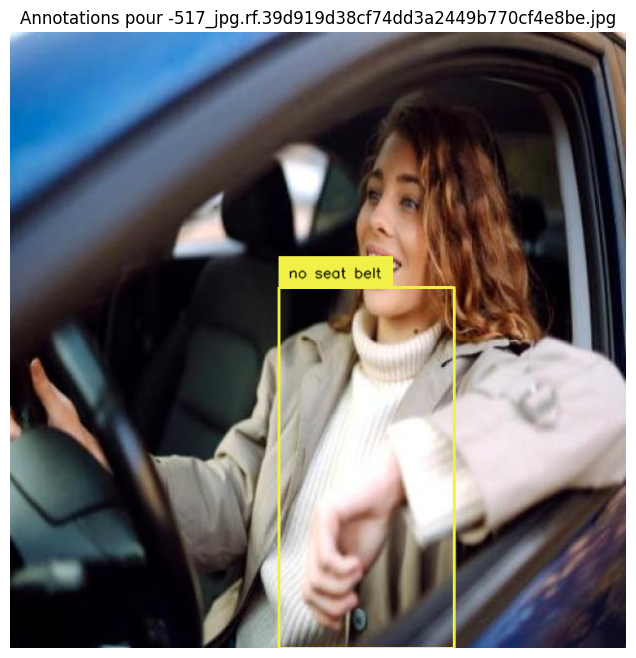

In [55]:
def visualize_coco_annotations(image_path, dataset=TRAIN_DATASET):
    # Vérifier si l'image existe
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image introuvable: {image_path}")
    
    # Extraire le nom de l'image
    image_name = os.path.basename(image_path)

    # Trouver l'ID correspondant
    image_id = None
    for img in dataset.coco.loadImgs(dataset.coco.getImgIds()):
        if img["file_name"] == image_name:
            image_id = img["id"]
            break
    
    if image_id is None:
        raise ValueError(f"Aucun ID trouvé pour l'image {image_name}")

    print(f"Image ID: {image_id}")

    # Charger l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR → RGB pour Matplotlib

    # Charger les annotations COCO associées
    annotations = dataset.coco.imgToAnns[image_id]
    if not annotations:
        raise ValueError(f"Aucune annotation trouvée pour l'image {image_id}")

    # Convertir en format utilisable par supervision
    detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

    # Récupérer les labels des catégories
    categories = dataset.coco.cats
    id2label = {k: v['name'] for k, v in categories.items()}
    
    labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]

    # Annoter l'image
    box_annotator = sv.BoxAnnotator()
    frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

    # Affichage avec Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(frame)
    plt.axis("off")  # Masquer les axes
    plt.title(f"Annotations pour {image_name}")
    plt.show()

# Exemple d'utilisation
test = f"{PATH}/train/-517_jpg.rf.39d919d38cf74dd3a2449b770cf4e8be.jpg"
visualize_coco_annotations(image_path=test)

In [56]:
def get_coco_class_distribution(title,dataset_path=TRAIN_DIRECTORY):
    # Charger les annotations COCO
    coco = COCO(f"{dataset_path}/_annotations.coco.json")

    # Récupérer les catégories
    categories = coco.cats
    id2label = {k: v['name'] for k, v in categories.items()}

    # Stocker le nombre d'instances par catégorie
    class_counts = Counter()

    # Récupérer toutes les annotations
    for ann in coco.anns.values():
        class_counts[ann['category_id']] += 1

    # Extraire les noms et occurrences des classes
    labels = [id2label[class_id] for class_id in class_counts.keys()]
    values = [class_counts[class_id] for class_id in class_counts.keys()]

    # Affichage des distributions
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color="skyblue")
    plt.xlabel("Classes")
    plt.ylabel("Nombre d'instances")
    plt.title(f"Distribution des classes dans le dataset {title}")
    plt.xticks(rotation=45)
    plt.show()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


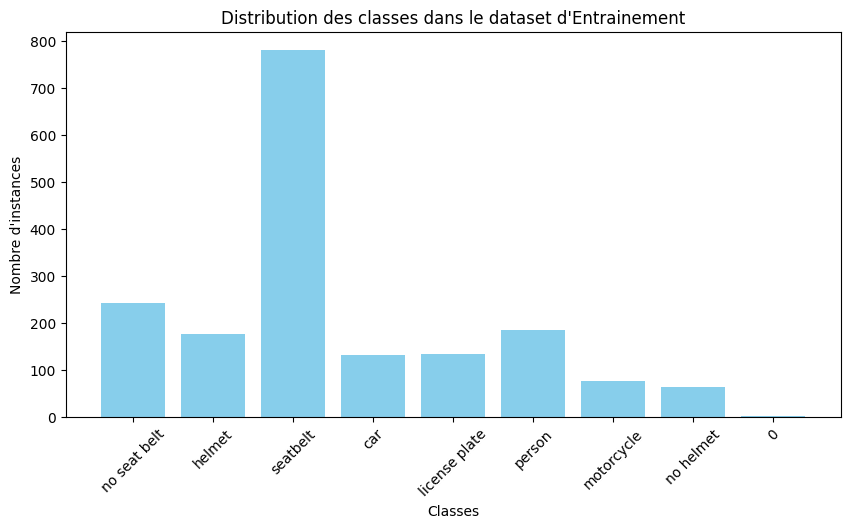

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


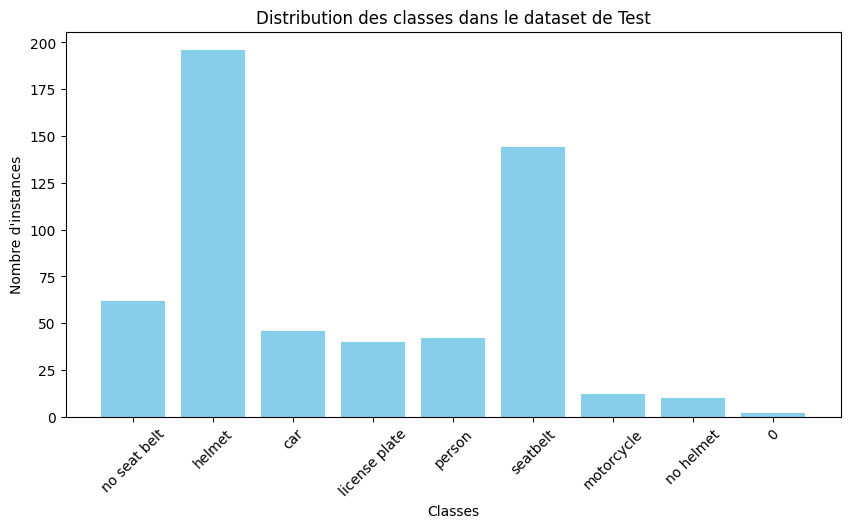

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


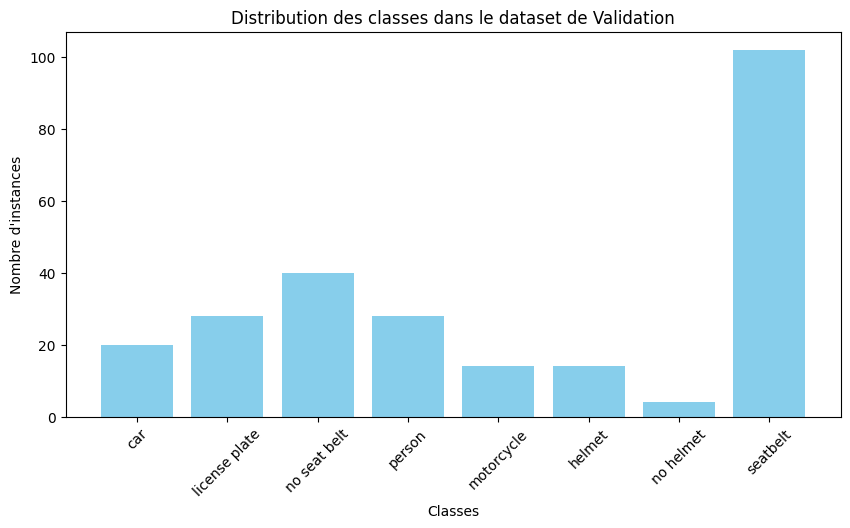

In [57]:
get_coco_class_distribution(title="d'Entrainement", dataset_path=TRAIN_DIRECTORY)
get_coco_class_distribution(title="de Test", dataset_path=VAL_DIRECTORY)
get_coco_class_distribution(title="de Validation", dataset_path=TEST_DIRECTORY)